<a href="https://colab.research.google.com/github/snvssk/data298A/blob/development/SolarModel_ANN_BigQuery_Insert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [2]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from google.cloud import bigquery

### Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read dataframe and Check Nulls

In [4]:
df= pd.read_csv('/content/drive/Shareddrives/DATA298/WeatherData/FinalWeatherData/all_cities_transformed_combined.csv')
df

,Unnamed: 0,Year,Month,Day,Hour,Minute,Temperature,Cloud_Type,Dew_Point,GHI,Relative_Humidity,Solar_Zenith_Angle,Surface_Albedo,Pressure,Precipitable_Water,Wind_Direction,Wind_Speed,Location
0,0,2018.0,1.0,1.0,0.0,0.0,11.2,4.0,10.2,0.0,93.63,165.41,0.100,1024.0,1.700,294.0,0.7,117987.0
1,1,2018.0,1.0,1.0,0.0,30.0,11.2,4.0,10.2,0.0,93.63,165.11,0.100,1024.0,1.700,307.0,0.7,117987.0
2,2,2018.0,1.0,1.0,1.0,0.0,11.1,4.0,10.1,0.0,93.38,162.29,0.100,1024.0,1.700,321.0,0.7,117987.0
3,3,2018.0,1.0,1.0,1.0,30.0,11.0,0.0,10.1,0.0,94.00,157.91,0.100,1024.0,1.800,332.0,0.7,117987.0
4,4,2018.0,1.0,1.0,2.0,0.0,10.9,0.0,9.9,0.0,93.32,152.72,0.100,1024.0,1.800,344.0,0.7,117987.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946181,946181,2013.0,12.0,31.0,21.0,30.0,6.0,1.0,0.0,0.0,74.05,142.58,0.113,1020.0,0.950,174.5,0.6,117546.0
946182,946182,2013.0,12.0,31.0,22.0,0.0,6.0,1.0,0.0,0.0,74.40,148.35,0.113,1020.0,0.977,152.1,0.9,117546.0
946183,946183,2013.0,12.0,31.0,22.0,30.0,5.0,0.0,0.0,0.0,79.80,153.89,0.113,1020.0,0.972,152.1,1.1,117546.0
946184,946184,2013.0,12.0,31.0,23.0,0.0,4.0,0.0,0.0,0.0,80.32,158.95,0.113,1020.0,0.968,166.7,1.3,117546.0


In [5]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature',
       'Cloud_Type', 'Dew_Point', 'GHI', 'Relative_Humidity',
       'Solar_Zenith_Angle', 'Surface_Albedo', 'Pressure',
       'Precipitable_Water', 'Wind_Direction', 'Wind_Speed', 'Location'],
      dtype='object')

### Check Null and Remove

In [6]:
# nsrdb_na = df.drop(columns='Unnamed: 0')
nsrdb_na = df.copy()
#null_rows = nsrdb_na[nsrdb_na.isna().any(axis=1)]
#null_rows
nsrdb_na.isnull().sum()
#nsrdb_na.columns
#nsrdb_na['GHI'].isnull().values.sum()
nsrdb = nsrdb_na.dropna()
#print(nsrdb)
nsrdb.isnull().sum()

Unnamed: 0            0
Year                  0
Month                 0
Day                   0
Hour                  0
Minute                0
Temperature           0
Cloud_Type            0
Dew_Point             0
GHI                   0
Relative_Humidity     0
Solar_Zenith_Angle    0
Surface_Albedo        0
Pressure              0
Precipitable_Water    0
Wind_Direction        0
Wind_Speed            0
Location              0
dtype: int64

## Feature Selection

In [ ]:
nsrdb = nsrdb.loc[(nsrdb['Hour'].isin([7, 10, 13, 16, 19])) & (nsrdb['Minute'] == 0)]

In [ ]:
target = nsrdb['GHI']
input= nsrdb.drop(['GHI'], axis=1)
input

,Unnamed: 0,Year,Month,Day,Hour,Minute,Temperature,Cloud_Type,Dew_Point,Relative_Humidity,Solar_Zenith_Angle,Surface_Albedo,Pressure,Precipitable_Water,Wind_Direction,Wind_Speed,Location
14,14,2018.0,1.0,1.0,7.0,0.0,9.8,7.0,8.8,93.25,94.85,0.100,1025.0,1.800,325.0,0.7,117987.0
20,20,2018.0,1.0,1.0,10.0,0.0,14.0,7.0,9.5,74.48,67.81,0.100,1026.0,1.800,24.0,1.5,117987.0
26,26,2018.0,1.0,1.0,13.0,0.0,17.6,7.0,8.6,55.38,61.32,0.100,1024.0,1.800,15.0,0.9,117987.0
32,32,2018.0,1.0,1.0,16.0,0.0,15.4,7.0,9.2,66.62,80.55,0.100,1023.0,1.800,14.0,0.8,117987.0
38,38,2018.0,1.0,1.0,19.0,0.0,12.8,7.0,8.3,74.04,112.83,0.100,1024.0,1.700,72.0,1.0,117987.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946152,946152,2013.0,12.0,31.0,7.0,0.0,9.0,7.0,8.0,100.00,94.75,0.111,1020.0,1.233,174.6,0.4,117546.0
946158,946158,2013.0,12.0,31.0,10.0,0.0,13.0,3.0,7.0,74.38,67.81,0.111,1020.0,1.403,23.4,0.7,117546.0
946164,946164,2013.0,12.0,31.0,13.0,0.0,17.0,7.0,4.0,49.14,61.44,0.111,1020.0,1.334,33.3,1.1,117546.0
946170,946170,2013.0,12.0,31.0,16.0,0.0,7.0,4.0,1.0,73.84,80.77,0.113,1020.0,0.999,343.0,0.8,117546.0


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.3, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=0)
forest = RandomForestClassifier(criterion='entropy',max_depth=3, n_estimators=500, random_state=0)

In [ ]:
forest.fit(x_train, y_train)
importances = forest.feature_importances_

In [ ]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_] , axis=0)
df = pd.DataFrame({'feature' : x_train.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')

In [ ]:
print(df)

               feature  importance       std
4               Minute    0.000000  0.000000
15            Location    0.000027  0.000602
11            Pressure    0.000062  0.000872
0                 Year    0.000455  0.001741
2                  Day    0.003226  0.009931
10      Surface_Albedo    0.003459  0.015442
12  Precipitable_Water    0.003639  0.011958
7            Dew_Point    0.007411  0.021134
13      Wind_Direction    0.010143  0.027043
14          Wind_Speed    0.027515  0.050844
1                Month    0.043073  0.066045
6           Cloud_Type    0.053154  0.073407
5          Temperature    0.090706  0.131901
8    Relative_Humidity    0.140360  0.163047
3                 Hour    0.204011  0.207794
9   Solar_Zenith_Angle    0.412759  0.283338


,feature,importance,std
0,Solar_Zenith_Angle,0.412759,0.283338
1,Hour,0.204011,0.207794
2,Relative_Humidity,0.140360,0.163047
3,Temperature,0.090706,0.131901
4,Cloud_Type,0.053154,0.073407
5,Month,0.043073,0.066045
6,Wind_Speed,0.027515,0.050844
7,Wind_Direction,0.010143,0.027043
8,Dew_Point,0.007411,0.021134
9,Precipitable_Water,0.003639,0.011958


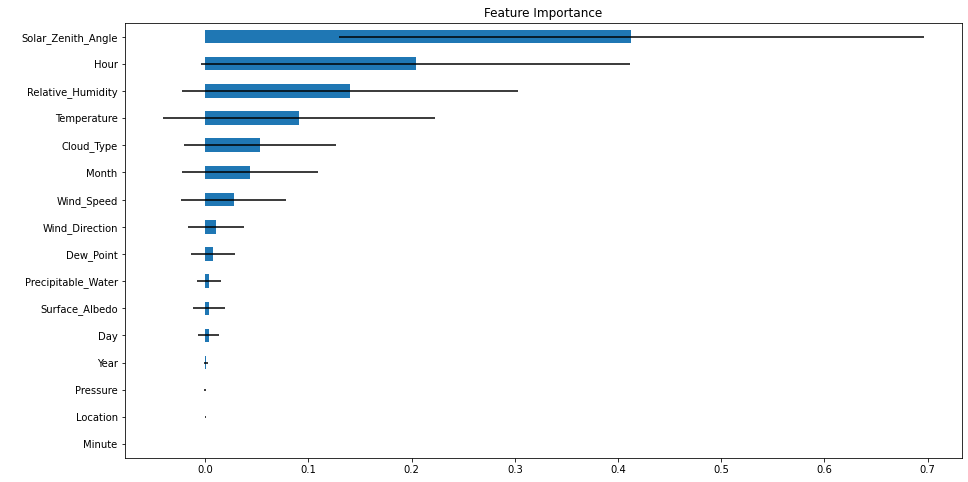

In [ ]:
ax = df.plot(kind='barh', xerr='std', x='feature', legend=False,figsize=(15, 8))
ax.set_ylabel(' ')
ax.set_title('Feature Importance')
df.sort_values(by=['importance'],ascending = False,ignore_index = True).head(16)

In [ ]:
df.sort_values(by=['importance'],ascending = False,ignore_index = True).head(16)

,feature,importance,std
0,Solar_Zenith_Angle,0.412759,0.283338
1,Hour,0.204011,0.207794
2,Relative_Humidity,0.140360,0.163047
3,Temperature,0.090706,0.131901
4,Cloud_Type,0.053154,0.073407
5,Month,0.043073,0.066045
6,Wind_Speed,0.027515,0.050844
7,Wind_Direction,0.010143,0.027043
8,Dew_Point,0.007411,0.021134
9,Precipitable_Water,0.003639,0.011958


In [ ]:
"""from datetime import datetime
nsrdb['Date'] = nsrdb.apply(lambda row: datetime.strptime(f"{int(row.Year)}-{int(row.Month)}-{int(row.Day)}", '%Y-%m-%d'), axis=1)
nsrdb['Date'] = pd.to_datetime(nsrdb['Date'])
nsrdb.info()
nsrdb = nsrdb.resample('D', on='Date').mean()
#nsrdb.drop(['Hour'],	['Minute'], axis=1)
nsrdb"""

## Train Model with selected features 11

In [39]:
nsrdb= pd.read_csv('/content/drive/Shareddrives/DATA298/WeatherData/FinalWeatherData/all_cities_transformed_combined.csv')
nsrdb = nsrdb.loc[(nsrdb['Hour'].isin([7, 10, 13, 16, 19])) & (nsrdb['Minute'] == 0)]
print(nsrdb.columns)
X = nsrdb.drop(['Unnamed: 0','GHI','Precipitable_Water', 'Surface_Albedo','Year','Pressure','Minute'], axis =1)
print(X.columns)
y=nsrdb['GHI']

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_normalized = sc.fit_transform(X)

from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(input_normalized,y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_text shape",y_test.shape)

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature',
       'Cloud_Type', 'Dew_Point', 'GHI', 'Relative_Humidity',
       'Solar_Zenith_Angle', 'Surface_Albedo', 'Pressure',
       'Precipitable_Water', 'Wind_Direction', 'Wind_Speed', 'Location'],
      dtype='object')
Index(['Month', 'Day', 'Hour', 'Temperature', 'Cloud_Type', 'Dew_Point',
       'Relative_Humidity', 'Solar_Zenith_Angle', 'Wind_Direction',
       'Wind_Speed', 'Location'],
      dtype='object')
x_train shape (48289, 11)
x_test shape (29565, 11)
y_train shape (48289,)
y_text shape (29565,)


In [40]:
# https://github.com/tpt5cu/solarIrradiancePredictor/blob/master/Neural_Net.ipynb
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
from random import randint
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Normalization())
model.add(layers.Dense(300, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(200, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(100, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(50, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(25, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(1, activation='relu', kernel_regularizer=regularizers.L1(0.01)))

#Compile and train
model.compile(optimizer=Adam(), 
              loss='mse',
              metrics=['mae',keras.metrics.RootMeanSquaredError()])

In [ ]:
"""keras.backend.clear_session()
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph"""

In [41]:
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_train,y_train),callbacks=[callback])

Epoch 1/100
755/755 [==============================] - 8s 9ms/step - loss: 16698.7656 - mae: 65.1943 - root_mean_squared_error: 129.0118 - val_loss: 3823.3608 - val_mae: 34.3180 - val_root_mean_squared_error: 61.4095
Epoch 2/100
755/755 [==============================] - 7s 9ms/step - loss: 3588.4807 - mae: 33.3215 - root_mean_squared_error: 59.4741 - val_loss: 3154.2656 - val_mae: 29.2042 - val_root_mean_squared_error: 55.7073
Epoch 3/100
755/755 [==============================] - 5s 7ms/step - loss: 3112.9756 - mae: 29.5416 - root_mean_squared_error: 55.3351 - val_loss: 2890.5842 - val_mae: 28.1139 - val_root_mean_squared_error: 53.2884
Epoch 4/100
755/755 [==============================] - 5s 7ms/step - loss: 2945.8101 - mae: 28.4727 - root_mean_squared_error: 53.8034 - val_loss: 2761.8696 - val_mae: 26.4743 - val_root_mean_squared_error: 52.0655
Epoch 5/100
755/755 [==============================] - 10s 13ms/step - loss: 2850.0808 - mae: 27.7449 - root_mean_squared_error: 52.9047 -

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 11)               23        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 300)               3600      
                                                                 
 dense_7 (Dense)             (None, 200)               60200     
                                                                 
 dense_8 (Dense)             (None, 100)               20100     
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 25)                1275      
                                                      

### Save model history in Json or CSV

In [ ]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history_epochs100_layers7_L2_reg_selectedfeatures_11.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# save to json:  
hist_json_file = 'history_epochs100_layers7_L2_reg_selectedfeatures_11.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

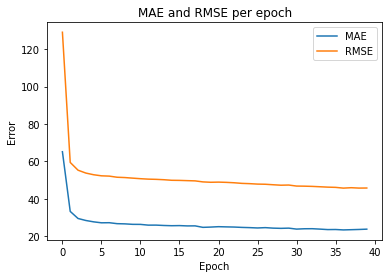

In [43]:
plt.plot(history.history['mae'])
plt.plot(history.history['root_mean_squared_error'])
plt.title('MAE and RMSE per epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['MAE', 'RMSE'], loc='upper right')
plt.show()

In [44]:
y_pred=model.predict(x_test)
y_pred

924/924 [==============================] - 4s 4ms/step


array([[  0.     ],
       [744.3603 ],
       [  0.     ],
       ...,
       [423.32278],
       [258.19257],
       [  0.     ]], dtype=float32)

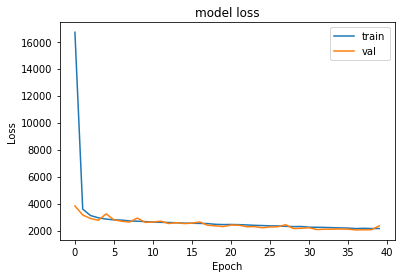

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [46]:
from sklearn.metrics import r2_score 
from sklearn import metrics
R_square = r2_score(y_test, y_pred) 
print('Coefficient of Determination R2', R_square)
print("Model MAE", metrics.mean_absolute_error(y_test, y_pred))
print("Model MSE", metrics.mean_squared_error(y_test, y_pred))
print("Model RMSE",np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Coefficient of Determination R2 0.9717837293999062
Model MAE 30.10841577063856
Model MSE 2936.9666438303893
Model RMSE 54.19378787121629


## Train Model with selected features 12 (Included Surface_Albedo)

In [ ]:
nsrdb= pd.read_csv('/content/drive/Shareddrives/DATA298/WeatherData/FinalWeatherData/all_cities_transformed_combined.csv')
nsrdb = nsrdb.loc[(nsrdb['Hour'].isin([7, 10, 13, 16, 19])) & (nsrdb['Minute'] == 0)]
print(nsrdb.columns)
X = nsrdb.drop(['Unnamed: 0','GHI','Precipitable_Water','Year','Pressure','Minute'], axis =1)
print(X.columns)
y=nsrdb['GHI']

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_normalized = sc.fit_transform(X)

from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(input_normalized,y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_text shape",y_test.shape)

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature',
       'Cloud_Type', 'Dew_Point', 'GHI', 'Relative_Humidity',
       'Solar_Zenith_Angle', 'Surface_Albedo', 'Pressure',
       'Precipitable_Water', 'Wind_Direction', 'Wind_Speed', 'Location'],
      dtype='object')
Index(['Month', 'Day', 'Hour', 'Temperature', 'Cloud_Type', 'Dew_Point',
       'Relative_Humidity', 'Solar_Zenith_Angle', 'Surface_Albedo',
       'Wind_Direction', 'Wind_Speed', 'Location'],
      dtype='object')
x_train shape (48289, 12)
x_test shape (29565, 12)
y_train shape (48289,)
y_text shape (29565,)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Normalization())
model.add(layers.Dense(300, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(200, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(100, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(50, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(25, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(1, activation='relu', kernel_regularizer=regularizers.L1(0.01)))

#Compile and train
model.compile(optimizer=Adam(), 
              loss='mse',
              metrics=['mae',keras.metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_train,y_train),callbacks=[callback])

Epoch 1/100
755/755 [==============================] - 8s 9ms/step - loss: 49794.2031 - mae: 114.6843 - root_mean_squared_error: 223.0976 - val_loss: 5468.2808 - val_mae: 47.0545 - val_root_mean_squared_error: 73.7964
Epoch 2/100
755/755 [==============================] - 6s 7ms/step - loss: 5134.4282 - mae: 44.8189 - root_mean_squared_error: 71.4968 - val_loss: 4860.6118 - val_mae: 43.2666 - val_root_mean_squared_error: 69.5545
Epoch 3/100
755/755 [==============================] - 5s 7ms/step - loss: 4301.7080 - mae: 38.1950 - root_mean_squared_error: 65.4138 - val_loss: 3855.5452 - val_mae: 35.5540 - val_root_mean_squared_error: 61.9108
Epoch 4/100
755/755 [==============================] - 7s 9ms/step - loss: 3596.1992 - mae: 32.8260 - root_mean_squared_error: 59.7835 - val_loss: 3446.8262 - val_mae: 31.7981 - val_root_mean_squared_error: 58.5238
Epoch 5/100
755/755 [==============================] - 9s 12ms/step - loss: 3468.3799 - mae: 31.7684 - root_mean_squared_error: 58.7092 -

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 12)               25        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 300)               3900      
                                                                 
 dense_7 (Dense)             (None, 200)               60200     
                                                                 
 dense_8 (Dense)             (None, 100)               20100     
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 25)                1275      
                                                      

### Save model history into Json

In [ ]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history_epochs100_layers7_L2_reg_selectedfeatures_12.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# save to json:  
hist_json_file = 'history_epochs100_layers7_L2_reg_selectedfeatures_12.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
y_pred=model.predict(x_test)
y_pred

924/924 [==============================] - 2s 2ms/step


array([[1.7789787e-01],
       [6.8605609e+02],
       [1.7623480e-01],
       ...,
       [4.2262793e+02],
       [2.3071266e+02],
       [1.7800853e-01]], dtype=float32)

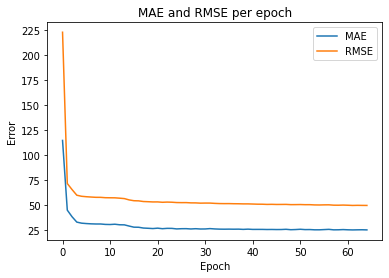

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['root_mean_squared_error'])
plt.title('MAE and RMSE per epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['MAE', 'RMSE'], loc='upper right')
plt.show()

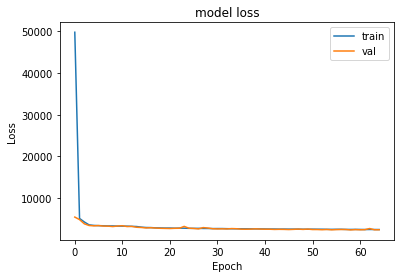

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import r2_score 
from sklearn import metrics
R_square = r2_score(y_test, y_pred) 
print('Coefficient of Determination R2', R_square)
print("Model MAE Selected Features 7 Layers", metrics.mean_absolute_error(y_test, y_pred))
print("Model MSE Selected Features 7 Layers", metrics.mean_squared_error(y_test, y_pred))
print("Model RMSE Selected Features 7 Layers",np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Coefficient of Determination R2 0.9736381981154622
Model MAE Selected Features 7 Layers 25.81504638758021
Model MSE Selected Features 7 Layers 2743.939264811825
Model RMSE Selected Features 7 Layers 52.38262369156231


## Train Model with all features and 6 Layers

In [ ]:
nsrdb= pd.read_csv('/content/drive/Shareddrives/DATA298/WeatherData/FinalWeatherData/all_cities_transformed_combined.csv')
nsrdb = nsrdb.loc[(nsrdb['Hour'].isin([7, 10, 13, 16, 19])) & (nsrdb['Minute'] == 0)]
print(nsrdb.columns)
X = nsrdb.drop(['Unnamed: 0','GHI'], axis =1)
print(X.columns)
y=nsrdb['GHI']

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_normalized = sc.fit_transform(X)

from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(input_normalized,y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_text shape",y_test.shape)

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature',
       'Cloud_Type', 'Dew_Point', 'GHI', 'Relative_Humidity',
       'Solar_Zenith_Angle', 'Surface_Albedo', 'Pressure',
       'Precipitable_Water', 'Wind_Direction', 'Wind_Speed', 'Location'],
      dtype='object')
Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Cloud_Type',
       'Dew_Point', 'Relative_Humidity', 'Solar_Zenith_Angle',
       'Surface_Albedo', 'Pressure', 'Precipitable_Water', 'Wind_Direction',
       'Wind_Speed', 'Location'],
      dtype='object')
x_train shape (48289, 16)
x_test shape (29565, 16)
y_train shape (48289,)
y_text shape (29565,)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Normalization())
#model.add(layers.Dense(300, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(200, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(100, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(50, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(25, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(1, activation='relu', kernel_regularizer=regularizers.L1(0.01)))

#Compile and train
model.compile(optimizer=Adam(), 
              loss='mse',
              metrics=['mae',keras.metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_train,y_train),callbacks=[callback])

Epoch 1/100
755/755 [==============================] - 5s 6ms/step - loss: 22022.1328 - mae: 77.8051 - root_mean_squared_error: 148.3035 - val_loss: 3923.0000 - val_mae: 35.0414 - val_root_mean_squared_error: 62.4001
Epoch 2/100
755/755 [==============================] - 4s 5ms/step - loss: 3616.2117 - mae: 33.2420 - root_mean_squared_error: 59.8910 - val_loss: 3221.1489 - val_mae: 30.3645 - val_root_mean_squared_error: 56.4962
Epoch 3/100
755/755 [==============================] - 4s 5ms/step - loss: 3097.3333 - mae: 29.9501 - root_mean_squared_error: 55.3873 - val_loss: 2968.5850 - val_mae: 28.8828 - val_root_mean_squared_error: 54.2108
Epoch 4/100
755/755 [==============================] - 5s 7ms/step - loss: 2759.8052 - mae: 27.1137 - root_mean_squared_error: 52.2488 - val_loss: 2663.7498 - val_mae: 27.1233 - val_root_mean_squared_error: 51.3208
Epoch 5/100
755/755 [==============================] - 4s 5ms/step - loss: 2643.1396 - mae: 26.1985 - root_mean_squared_error: 51.1195 - v

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 16)               33        
 ion)                                                            
                                                                 
 dense_12 (Dense)            (None, 200)               3400      
                                                                 
 dense_13 (Dense)            (None, 100)               20100     
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dense_15 (Dense)            (None, 25)                1275      
                                                                 
 dense_16 (Dense)            (None, 1)                 26        
                                                      

### Save model history into Json

In [ ]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history_epochs100_layers6_L2_reg_AllFeatures.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# save to json:  
hist_json_file = 'history_epochs100_layers6_L2_reg_AllFeatures_12.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
y_pred=model.predict(x_test)
y_pred

924/924 [==============================] - 2s 2ms/step


array([[  0.     ],
       [711.9729 ],
       [  0.     ],
       ...,
       [422.84656],
       [241.76868],
       [  0.     ]], dtype=float32)

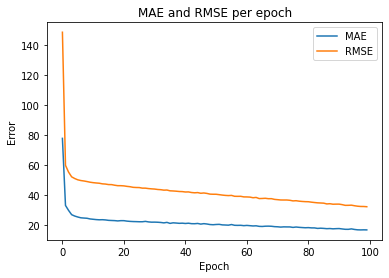

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['root_mean_squared_error'])
plt.title('MAE and RMSE per epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['MAE', 'RMSE'], loc='upper right')
plt.show()

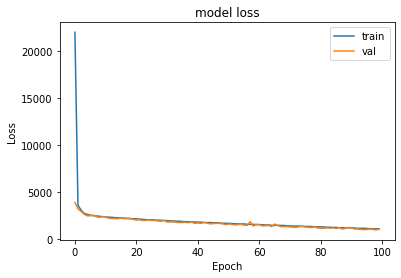

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import r2_score 
from sklearn import metrics
R_square = r2_score(y_test, y_pred) 
print('Coefficient of Determination R2', R_square)
print("Model MAE All Features 6 Layers", metrics.mean_absolute_error(y_test, y_pred))
print("Model MSE All Features 6 Layers", metrics.mean_squared_error(y_test, y_pred))
print("Model RMSE All Features 6 Layers",np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Coefficient of Determination R2 0.9757875426018217
Model MAE All Features 6 Layers 22.652943466150397
Model MSE All Features 6 Layers 2520.218945709209
Model RMSE All Features 6 Layers 50.20178229614173


## Train Model with selected features and 8 Layers less neurons in hidden layers, batch size = 32, epochs=200

In [28]:
nsrdb= pd.read_csv('/content/drive/Shareddrives/DATA298/WeatherData/FinalWeatherData/all_cities_transformed_combined.csv')
nsrdb = nsrdb.loc[(nsrdb['Hour'].isin([7, 10, 13, 16, 19])) & (nsrdb['Minute'] == 0)]
print(nsrdb.columns)
X = nsrdb.drop(['Unnamed: 0','GHI','Surface_Albedo','Precipitable_Water','Year','Pressure','Minute'], axis =1)
print(X.columns)
y=nsrdb['GHI']

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_normalized = sc.fit_transform(X)

from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(input_normalized,y, test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_text shape",y_test.shape)

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature',
       'Cloud_Type', 'Dew_Point', 'GHI', 'Relative_Humidity',
       'Solar_Zenith_Angle', 'Surface_Albedo', 'Pressure',
       'Precipitable_Water', 'Wind_Direction', 'Wind_Speed', 'Location'],
      dtype='object')
Index(['Month', 'Day', 'Hour', 'Temperature', 'Cloud_Type', 'Dew_Point',
       'Relative_Humidity', 'Solar_Zenith_Angle', 'Wind_Direction',
       'Wind_Speed', 'Location'],
      dtype='object')
x_train shape (48289, 11)
x_test shape (29565, 11)
y_train shape (48289,)
y_text shape (29565,)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Normalization())
model.add(layers.Dense(100, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(80, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(70, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(60, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(50, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(25, activation="relu", kernel_regularizer=regularizers.L1(0.01)))
model.add(layers.Dense(1, activation='relu', kernel_regularizer=regularizers.L1(0.01)))

#Compile and train
model.compile(optimizer=Adam(), 
              loss='mse',
              metrics=['mae',keras.metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_train,y_train),callbacks=[callback])

Epoch 1/200
1510/1510 [==============================] - 9s 5ms/step - loss: 39969.1602 - mae: 99.5369 - root_mean_squared_error: 199.9098 - val_loss: 5111.2207 - val_mae: 44.1509 - val_root_mean_squared_error: 71.4592
Epoch 2/200
1510/1510 [==============================] - 8s 5ms/step - loss: 5061.8423 - mae: 44.5831 - root_mean_squared_error: 71.1133 - val_loss: 4761.9502 - val_mae: 42.8933 - val_root_mean_squared_error: 68.9728
Epoch 3/200
1510/1510 [==============================] - 8s 5ms/step - loss: 4859.3701 - mae: 43.2842 - root_mean_squared_error: 69.6749 - val_loss: 5374.8149 - val_mae: 45.7918 - val_root_mean_squared_error: 73.2796
Epoch 4/200
1510/1510 [==============================] - 8s 5ms/step - loss: 4709.1836 - mae: 42.2956 - root_mean_squared_error: 68.5871 - val_loss: 4560.8628 - val_mae: 40.6242 - val_root_mean_squared_error: 67.4964
Epoch 5/200
1510/1510 [==============================] - 8s 5ms/step - loss: 4604.0449 - mae: 41.2846 - root_mean_squared_error: 6

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 11)               23        
 ion)                                                            
                                                                 
 dense_17 (Dense)            (None, 100)               1200      
                                                                 
 dense_18 (Dense)            (None, 80)                8080      
                                                                 
 dense_19 (Dense)            (None, 70)                5670      
                                                                 
 dense_20 (Dense)            (None, 60)                4260      
                                                                 
 dense_21 (Dense)            (None, 50)                3050      
                                                      

### Save model history into Json

In [ ]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history_epochs200_layers8_L2_reg_SelectedFeatures_batch32_DifferentLayerStructure.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# save to json:  
hist_json_file = 'history_epochs200_layers8_L2_reg_SelectedFeatures_batch32_DifferentLayerStructure.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
y_pred=model.predict(x_test)
y_pred

924/924 [==============================] - 2s 2ms/step


array([[  1.0206823],
       [712.1481   ],
       [  1.0206823],
       ...,
       [432.1627   ],
       [228.7662   ],
       [  1.0206823]], dtype=float32)

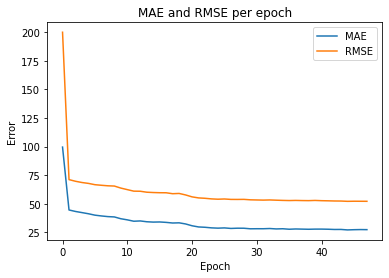

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['root_mean_squared_error'])
plt.title('MAE and RMSE per epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['MAE', 'RMSE'], loc='upper right')
plt.show()

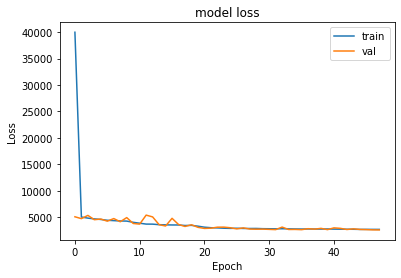

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import r2_score 
from sklearn import metrics
R_square = r2_score(y_test, y_pred) 
print('Coefficient of Determination R2', R_square)
print("Model MAE Selected Features 8 Layers", metrics.mean_absolute_error(y_test, y_pred))
print("Model MSE Selected  Features 8 Layers", metrics.mean_squared_error(y_test, y_pred))
print("Model RMSE Selected  Features 8 Layers",np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Coefficient of Determination R2 0.9727355964196602
Model MAE Selected Features 8 Layers 27.58347840250274
Model MSE Selected  Features 8 Layers 2837.8889972483316
Model RMSE Selected  Features 8 Layers 53.27184056561526


## Upload model history into Bigquery

In [47]:
from google.cloud import bigquery
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file('/content/drive/Shareddrives/DATA298/BigQuery/data298-347103-eaa0e3e59658.json')

project_id = 'data298-347103'
# Construct a BigQuery client object.
#OAuth2ClientId = AdwordsModel.OAuth2ClientId
client = bigquery.Client(credentials=credentials,project=project_id)

# Set table_id to the ID of the table model to fetch.
table_id = 'data298-347103.projectReports.ModelPerformanceResults'

# Make an API request.
table = client.get_table(table_id)  

# View table properties
print(f"Got table {table_id}.")
#print(f"Table schema: {table.schema}")
#print(f"Table description: {table.description}")
#print(f"Table has {table.num_rows} rows")

Got table data298-347103.projectReports.ModelPerformanceResults.


In [49]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [70]:
#BigQuery Client
import json
from pprint import pprint
project_id = 'data298-347103'
client = bigquery.Client(project=project_id)
#BigQuery Lookup for Address
insert_sql = """INSERT INTO `data298-347103.projectReports.ModelPerformanceResults` 
                           VALUES(@datevalue, @model_config,@model_name,@target_objective,@iteration,@epoch,@training_metrics,@validation_metrics,@execution_time,@github_link)"""

hist_df = pd.DataFrame(history.history) 
metrics_results = json.loads(hist_df.to_json())
print(type(metrics_results))

for i in range(0, 1):
  epoch_number = i+1
  idx = str(i)
  #print(metrics_results[0])
  training_metrics = {'loss':metrics_results['loss'][idx],'mae':metrics_results['mae'][idx],'root_mean_squared_error':metrics_results['root_mean_squared_error'][idx]}
  validation_metrics = {'val_loss':metrics_results['val_loss'][idx],'val_mae':metrics_results['val_mae'][idx],'val_root_mean_squared_error':metrics_results['val_root_mean_squared_error'][idx] }
  print(type(json.dumps(training_metrics)))
  print(type(json.dumps(validation_metrics)))
  job_config = bigquery.QueryJobConfig(
  query_parameters=[
      bigquery.ScalarQueryParameter("datevalue","TIMESTAMP",'2022-12-06 02:08:28.801628 UTC'),
      bigquery.ScalarQueryParameter("model_config", "JSON", model.to_json()),
      bigquery.ScalarQueryParameter("model_name", "STRING", 'ANN'),
      bigquery.ScalarQueryParameter("target_objective", "STRING", 'SolarEnergyEstimation'),
      bigquery.ScalarQueryParameter("iteration", "INTEGER", 0),
      bigquery.ScalarQueryParameter("epoch", "INTEGER", epoch_number),
      bigquery.ScalarQueryParameter("training_metrics", "JSON", json.dumps(training_metrics)),
      bigquery.ScalarQueryParameter("validation_metrics", "JSON", json.dumps(validation_metrics)),
      bigquery.ScalarQueryParameter("execution_time", "INTEGER", 0),
      bigquery.ScalarQueryParameter('github_link','STRING','https://github.com/snvssk/data298A/blob/main/SolarEnergy/MLModels/ANN.ipynb')
  ]
  )
  #print(insert_sql)       
  insert_result = client.query(insert_sql,job_config=job_config) 
  print(insert_result)
  
  pprint(vars(insert_result))
  #print(insert_result.query['query'])
  print(insert_result.errors)


<class 'dict'>
<class 'str'>
<class 'str'>
QueryJob<project=data298-347103, location=us-east1, id=e80b80d7-fa0b-49f8-bc59-55478c29def4>
{'_client': <google.cloud.bigquery.client.Client object at 0x7f8749287700>,
 '_completion_lock': <unlocked _thread.lock object at 0x7f87492ea960>,
 '_configuration': <google.cloud.bigquery.job.query.QueryJobConfig object at 0x7f87492eaee0>,
 '_done_callbacks': [],
 '_done_timeout': None,
 '_exception': None,
 '_job_retry': <google.api_core.retry.Retry object at 0x7f87b2b25e50>,
 '_polling_thread': None,
 '_properties': {'configuration': {'jobType': 'QUERY',
                                   'query': {'destinationTable': {'datasetId': 'projectReports',
                                                                  'projectId': 'data298-347103',
                                                                  'tableId': 'ModelPerformanceResults'},
                                             'parameterMode': 'NAMED',
                                

In [27]:
# #BigQuery Client
# import json
# project_id = 'data298-347103'
# client = bigquery.Client(project=project_id)
# #BigQuery Lookup for Address
# insert_sql = """INSERT INTO `data298-347103.projectReports.ModelPerformanceResults` 
#                            VALUES(current_timestamp(), @model_config,@model_name,@target_objective,@iteration,@epoch,@training_metrics,@validation_metrics,@execution_time,@github_link,)"""

# metrics_results = json.loads(hist_df.to_json())
# print(type(metrics_results))

# for i in range(0, 10):
#   epoch_number = i+1
#   idx = str(i)
#   #print(metrics_results[0])
#   training_metrics = {'loss':metrics_results['loss'][idx],'mae':metrics_results['mae'][idx],'root_mean_squared_error':metrics_results['root_mean_squared_error'][idx]}
#   validation_metrics = {'val_loss':metrics_results['val_loss'][idx],'val_mae':metrics_results['val_mae'][idx],'val_root_mean_squared_error':metrics_results['val_root_mean_squared_error'][idx] }
#   job_config = bigquery.QueryJobConfig(
#   query_parameters=[
#       bigquery.ScalarQueryParameter("model_config", "JSON", model.to_json()),
#       bigquery.ScalarQueryParameter("model_name", "STRING", 'ANN'),
#       bigquery.ScalarQueryParameter("target_objective", "STRING", 'SolarEnergyEstimation'),
#       bigquery.ScalarQueryParameter("iteration", "INTEGER", 0),
#       bigquery.ScalarQueryParameter("epoch", "INTEGER", epoch_number),
#       bigquery.ScalarQueryParameter("training_metrics", "JSON", training_metrics),
#       bigquery.ScalarQueryParameter("validation_metrics", "JSON", validation_metrics),
#       bigquery.ScalarQueryParameter("execution_time", "INTEGER", 0),
#       bigquery.ScalarQueryParameter('github_link','STRING','https://github.com/snvssk/data298A/blob/main/SolarEnergy/MLModels/ANN.ipynb')
#   ]
#   )
          
#   insert_result = client.query(insert_sql,job_config=job_config) 
#   print(insert_result)"""

In [51]:
print(insert_result.errors)

[{'reason': 'invalidQuery', 'location': 'query', 'message': 'Syntax error: Unexpected ")" at [2:185]'}]


## Model Artifacts save into folder for deployement
### Delete saved model before saving another time

In [ ]:
rm -rf '/content/drive/MyDrive/my_model'

In [ ]:
model.save('/content/drive/MyDrive/ANN_5Points_FeatureSelected_1000epochs')

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['root_mean_squared_error'])
plt.title('mae and rmse per epoch')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['MAE', 'RMSE'], loc='upper left')
plt.show()

In [ ]:
y_pred=model.predict(x_test)
y_pred

In [ ]:
from sklearn.metrics import r2_score 
from sklearn import metrics
R_square = r2_score(y_test, y_pred) 
print('Coefficient of Determination R2', R_square)
print("Model MAE", metrics.mean_absolute_error(y_test, y_pred))
print("Model MSE", metrics.mean_squared_error(y_test, y_pred))
print("Model RMSE",np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

Coefficient of Determination R2 0.977652089983716
Model MAE 21.81954326999383
Model MSE 2326.142501515815
Model RMSE 48.230099538730116


### The model validated with 30% data and the validation MAE we got 11.68 w/m2, and RMSE 33.17 w/m2. Might be the validation dataset location is different than the training dataset. So, we got bit high MAE and RMSE. We will validate the model with a new location and observe the errors. However, it still performed surprisingly well. 

# Test with new location

## Cupertino

In [ ]:
import pandas as pd
df =pd.read_csv('/content/drive/Shareddrives/DATA298/WeatherData/FinalWeatherData/cupertino_test.csv')
#df

In [ ]:
null = df[df.isna().any(axis=1)]
df = df.dropna()
df.isnull().sum()

df = df.loc[(df['Hour'].isin([7, 10, 13, 16, 19])) & (df['Minute'] == 0)]

input_test = df.drop(['Unnamed: 0','GHI','Precipitable_Water', 'Surface_Albedo','Year','Pressure','Minute'], axis =1)
input_test

target_test=df['GHI']
target_test

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_nor_test = sc.fit_transform(input_test)
y_pred_test=model.predict(input_nor_test)
y_pred_test

from sklearn import metrics
print("Model MAE", metrics.mean_absolute_error(target_test, y_pred_test))
print("Model MSE", metrics.mean_squared_error(target_test, y_pred_test))
print("Model RMSE",np.sqrt(metrics.mean_squared_error(target_test, y_pred_test)))

115/115 [==============================] - 0s 2ms/step
Model MAE 28.456212397666828
Model MSE 3054.3011576390622
Model RMSE 55.265732218428646


## FosterCity

In [ ]:
df =pd.read_csv('/content/drive/Shareddrives/DATA298/WeatherData/FinalWeatherData/fostercity_test.csv')
df

,Unnamed: 0,Year,Month,Day,Hour,Minute,Temperature,Cloud_Type,Dew_Point,GHI,Relative_Humidity,Solar_Zenith_Angle,Surface_Albedo,Pressure,Precipitable_Water,Wind_Direction,Wind_Speed,Location
0,0,2019.0,1.0,1.0,0.0,0.0,5.3,0.0,1.1,0.0,74.37,165.21,0.09,1028.0,0.3,29.0,5.0,120198.0
1,1,2019.0,1.0,1.0,0.0,30.0,5.1,0.0,1.1,0.0,75.41,164.97,0.09,1028.0,0.3,30.0,5.0,120198.0
2,2,2019.0,1.0,1.0,1.0,0.0,5.0,0.0,0.8,0.0,74.07,162.23,0.09,1029.0,0.3,30.0,4.9,120198.0
3,3,2019.0,1.0,1.0,1.0,30.0,5.0,0.0,0.8,0.0,74.07,157.91,0.09,1029.0,0.3,31.0,4.9,120198.0
4,4,2019.0,1.0,1.0,2.0,0.0,4.9,0.0,0.2,0.0,71.60,152.76,0.09,1029.0,0.3,31.0,4.9,120198.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35037,35037,2020.0,12.0,31.0,21.0,30.0,11.1,7.0,9.7,0.0,91.09,142.44,0.09,1030.0,1.1,297.0,2.5,120198.0
35038,35038,2020.0,12.0,31.0,22.0,0.0,10.6,7.0,10.1,0.0,97.02,148.20,0.09,1030.0,1.2,300.0,2.9,120198.0
35039,35039,2020.0,12.0,31.0,22.0,30.0,10.4,7.0,10.1,0.0,98.32,153.71,0.09,1030.0,1.2,303.0,3.1,120198.0
35040,35040,2020.0,12.0,31.0,23.0,0.0,10.2,7.0,10.2,0.0,100.00,158.76,0.09,1030.0,1.2,307.0,3.3,120198.0


In [ ]:
null = df[df.isna().any(axis=1)]
df = df.dropna()
df.isnull().sum()

df = df.loc[(df['Hour'].isin([7, 10, 13, 16, 19])) & (df['Minute'] == 0)]

input_test = df.drop(['Unnamed: 0','GHI','Precipitable_Water', 'Surface_Albedo','Year','Pressure','Minute'], axis =1)
input_test

target_test=df['GHI']
target_test

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_nor_test = sc.fit_transform(input_test)
y_pred_test=model.predict(input_nor_test)
y_pred_test

from sklearn import metrics
print("Model MAE", metrics.mean_absolute_error(target_test, y_pred_test))
print("Model MSE", metrics.mean_squared_error(target_test, y_pred_test))
print("Model RMSE",np.sqrt(metrics.mean_squared_error(target_test, y_pred_test)))

115/115 [==============================] - 0s 2ms/step
Model MAE 27.817592678298688
Model MSE 3151.8031092700794
Model RMSE 56.14092187762933


In [ ]:
"""df = df.loc[(df['Hour'].isin([7, 10, 13, 16, 19])) & (df['Minute'] == 0)]
df = df.drop(['Unnamed: 0'],axis =1)
null = df[df.isna().any(axis=1)]
df = df.dropna()
df.isnull().sum()

target_test = df['GHI']#keeping only target(ghi) data here
input_test= df.drop(['GHI'], axis=1)
input_test.head()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_nor_test = sc.fit_transform(input_test)
y_pred_test=model.predict(input_nor_test)
y_pred_test

from sklearn import metrics
print("Model MAE", metrics.mean_absolute_error(target_test, y_pred_test))
print("Model MSE", metrics.mean_squared_error(target_test, y_pred_test))
print("Model RMSE",np.sqrt(metrics.mean_squared_error(target_test, y_pred_test)))"""

115/115 [==============================] - 0s 2ms/step
Model MAE 29.19396081330025
Model MSE 3869.01764842444
Model RMSE 62.201428025604365


### LosGatos

In [ ]:
df =pd.read_csv('/content/drive/Shareddrives/DATA298/WeatherData/FinalWeatherData/losgatos_test.csv')
df

,Unnamed: 0,Year,Month,Day,Hour,Minute,Temperature,Cloud_Type,Dew_Point,GHI,Relative_Humidity,Solar_Zenith_Angle,Surface_Albedo,Pressure,Precipitable_Water,Wind_Direction,Wind_Speed,Location
0,0,2019.0,1.0,1.0,0.0,0.0,3.3,0.0,-0.9,0.0,73.88,165.55,0.12,1016.0,0.3,29.0,1.9,116662.0
1,1,2019.0,1.0,1.0,0.0,30.0,3.1,0.0,-0.9,0.0,74.93,165.20,0.12,1016.0,0.3,26.0,1.9,116662.0
2,2,2019.0,1.0,1.0,1.0,0.0,2.9,0.0,-1.3,0.0,73.65,162.32,0.12,1016.0,0.3,24.0,1.9,116662.0
3,3,2019.0,1.0,1.0,1.0,30.0,2.9,0.0,-1.3,0.0,73.72,157.90,0.12,1017.0,0.3,19.0,1.9,116662.0
4,4,2019.0,1.0,1.0,2.0,0.0,2.8,0.0,-1.8,0.0,71.84,152.68,0.12,1017.0,0.3,15.0,2.0,116662.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35037,35037,2020.0,12.0,31.0,21.0,30.0,10.7,7.0,7.5,0.0,80.58,142.72,0.12,1018.0,1.0,235.0,1.1,116662.0
35038,35038,2020.0,12.0,31.0,22.0,0.0,10.2,7.0,7.9,0.0,85.47,148.50,0.12,1018.0,1.0,251.0,1.4,116662.0
35039,35039,2020.0,12.0,31.0,22.0,30.0,9.6,7.0,7.9,0.0,88.96,154.05,0.12,1018.0,1.0,260.0,1.5,116662.0
35040,35040,2020.0,12.0,31.0,23.0,0.0,9.1,7.0,8.6,0.0,96.76,159.12,0.12,1018.0,1.1,269.0,1.6,116662.0


In [ ]:
null = df[df.isna().any(axis=1)]
df = df.dropna()
df.isnull().sum()

df = df.loc[(df['Hour'].isin([7, 10, 13, 16, 19])) & (df['Minute'] == 0)]

input_test = df.drop(['Unnamed: 0','GHI','Precipitable_Water', 'Surface_Albedo','Year','Pressure','Minute'], axis =1)
input_test

target_test=df['GHI']
target_test

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_nor_test = sc.fit_transform(input_test)
y_pred_test=model.predict(input_nor_test)
y_pred_test

from sklearn import metrics
print("Model MAE", metrics.mean_absolute_error(target_test, y_pred_test))
print("Model MSE", metrics.mean_squared_error(target_test, y_pred_test))
print("Model RMSE",np.sqrt(metrics.mean_squared_error(target_test, y_pred_test)))

115/115 [==============================] - 0s 2ms/step
Model MAE 28.612866300687397
Model MSE 3027.5059819944336
Model RMSE 55.022776938231985


In [ ]:
"""df = df.loc[(df['Hour'].isin([7, 10, 13, 16, 19])) & (df['Minute'] == 0)]
df = df.drop(['Unnamed: 0'],axis =1)
null = df[df.isna().any(axis=1)]
df = df.dropna()
df.isnull().sum()

target_test = df['GHI']#keeping only target(ghi) data here
input_test= df.drop(['GHI'], axis=1)
input_test.head()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_nor_test = sc.fit_transform(input_test)
y_pred_test=model.predict(input_nor_test)
y_pred_test

from sklearn import metrics
print("Model MAE", metrics.mean_absolute_error(target_test, y_pred_test))
print("Model MSE", metrics.mean_squared_error(target_test, y_pred_test))
print("Model RMSE",np.sqrt(metrics.mean_squared_error(target_test, y_pred_test)))"""

'df = df.loc[(df[\'Hour\'].isin([7, 10, 13, 16, 19])) & (df[\'Minute\'] == 0)]\ndf = df.drop([\'Unnamed: 0\'],axis =1)\nnull = df[df.isna().any(axis=1)]\ndf = df.dropna()\ndf.isnull().sum()\n\ntarget_test = df[\'GHI\']#keeping only target(ghi) data here\ninput_test= df.drop([\'GHI\'], axis=1)\ninput_test.head()\n\nfrom sklearn.preprocessing import StandardScaler\nsc = StandardScaler()\ninput_nor_test = sc.fit_transform(input_test)\ny_pred_test=model.predict(input_nor_test)\ny_pred_test\n\nfrom sklearn import metrics\nprint("Model MAE", metrics.mean_absolute_error(target_test, y_pred_test))\nprint("Model MSE", metrics.mean_squared_error(target_test, y_pred_test))\nprint("Model RMSE",np.sqrt(metrics.mean_squared_error(target_test, y_pred_test)))'

### Saratoga

In [ ]:
df =pd.read_csv('/content/drive/Shareddrives/DATA298/WeatherData/FinalWeatherData/saratoga_2020.csv')
df

,Year,Month,Day,Hour,Minute,Temperature,Cloud Type,Dew Point,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Location
0,2020,1,1,0,0,8.3,7,8.3,0,100.00,165.59,0.11,1006,1.0,319,1.7,116661
1,2020,1,1,0,30,8.5,7,8.5,0,100.00,165.23,0.11,1006,1.1,327,1.6,116661
2,2020,1,1,1,0,8.7,7,8.7,0,100.00,162.35,0.11,1006,1.1,336,1.6,116661
3,2020,1,1,1,30,8.8,7,8.8,0,100.00,157.92,0.11,1006,1.1,336,1.5,116661
4,2020,1,1,2,0,8.9,7,8.9,0,100.00,152.69,0.11,1006,1.1,337,1.4,116661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2020,12,31,21,30,10.2,7,7.5,0,83.23,142.70,0.11,1006,0.9,323,1.1,116661
17516,2020,12,31,22,0,9.7,7,7.8,0,88.11,148.49,0.11,1006,1.0,294,1.4,116661
17517,2020,12,31,22,30,9.1,7,7.8,0,91.73,154.04,0.11,1006,1.0,298,1.6,116661
17518,2020,12,31,23,0,8.6,7,8.5,0,99.42,159.12,0.11,1006,1.0,302,1.7,116661


In [ ]:
null = df[df.isna().any(axis=1)]
df = df.dropna()
df.isnull().sum()

df = df.loc[(df['Hour'].isin([7, 10, 13, 16, 19])) & (df['Minute'] == 0)]

input_test =df.drop(['Surface Albedo','Precipitable Water','GHI','Year','Pressure','Minute'], axis=1)
input_test

target_test=df['GHI']
target_test

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_nor_test = sc.fit_transform(input_test)
y_pred_test=model.predict(input_nor_test)
y_pred_test

from sklearn import metrics
print("Model MAE", metrics.mean_absolute_error(target_test, y_pred_test))
print("Model MSE", metrics.mean_squared_error(target_test, y_pred_test))
print("Model RMSE",np.sqrt(metrics.mean_squared_error(target_test, y_pred_test)))

58/58 [==============================] - 0s 2ms/step
Model MAE 27.304809762353766
Model MSE 2987.8395232790194
Model RMSE 54.66113357111266


In [ ]:
"""df = df.loc[(df['Hour'].isin([7, 10, 13, 16, 19])) & (df['Minute'] == 0)]
#df = df.drop(['Unnamed: 0'],axis =1)
null = df[df.isna().any(axis=1)]
df = df.dropna()
df.isnull().sum()

target_test = df['GHI']#keeping only target(ghi) data here
input_test= df.drop(['GHI'], axis=1)
input_test.head()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
input_nor_test = sc.fit_transform(input_test)
y_pred_test=model.predict(input_nor_test)
y_pred_test

from sklearn import metrics
print("Model MAE", metrics.mean_absolute_error(target_test, y_pred_test))
print("Model MSE", metrics.mean_squared_error(target_test, y_pred_test))
print("Model RMSE",np.sqrt(metrics.mean_squared_error(target_test, y_pred_test)))"""

58/58 [==============================] - 0s 2ms/step
Model MAE 28.052558402361935
Model MSE 3582.6169744593362
Model RMSE 59.854966163713904
